Since the outbreak of the COVID-19 pandemic, there has been a massive pursuit by the research community to find drugs to treat this disease as well as discover vaccines against the disease. A large number of research papers have been published to this end, peer-reviewed as well as those posted in preprint repositories such as bioRxiv and medRxiv. In addition, a large number of peer-reviewed papers on earlier coronavirus-related diseases such as SARS and MERS are also available.

The COVID-19 Open Research Dataset (CORD-19 corpus) consists of abstracts and full-text articles on COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community via this Kaggle challenge to apply recent advances in natural language processing (NLP) and other related techniques to generate insights in support of the ongoing fight against this infectious disease.

At a specific level, it means we have to help uncover "unknown known" entities such as drugs and vaccines that are maybe unknown to the larger set of researchers but mentioned in specific scientific article(s) part of the CORD-19 dataset. **Our goal is to help the medical research community uncover these "unknown known" entities through a combination of text-mining and network analyses.**

In [ ]:
import pandas as pd
import sys
#Install pyTigerGraph package in the google colab
!pip install -U pyTigerGraph
#Import and implement these packages that we install previously
import pyTigerGraph as tg

temp = pd.DataFrame(columns=['source','target','Relation'])
VERSION_DIR = '../input/cord19/drug_submission_v2.3/'
ENTITY_NAME_FILE = VERSION_DIR + 'resources/entity_name.tsv'
ENT_METADATA_FILE = VERSION_DIR + 'resources/entity_metadata.csv'
CONETZ_SP_NETWORK_FILE = VERSION_DIR + 'conetz_specialized.tsv'
NETWORK_FILE = CONETZ_SP_NETWORK_FILE

In [ ]:
#Reading the dataset
pd.read_csv(ENT_METADATA_FILE, sep=',')

,entid,enttype,entcolor,entsource
0,1,GENE HUMAN,#717afa,https://www.genenames.org/
1,2,GENE SARS,#717afa,https://www.ncbi.nlm.nih.gov/gene/
2,3,GENE MERS,#717afa,https://www.ncbi.nlm.nih.gov/gene/
3,4,GENE SARS-CoV-2,#717afa,https://www.ncbi.nlm.nih.gov/gene/
4,5,HPO PHENOTYPES,#ff0000,https://www.nlm.nih.gov/mesh/meshhome.html
5,7,CHEMICALS,#bd576f,https://www.nlm.nih.gov/mesh/meshhome.html
6,8,DRUGS,#bd576f,https://www.nlm.nih.gov/mesh/meshhome.html
7,9,DISEASE,#fb8b07,https://www.nlm.nih.gov/mesh/meshhome.html
8,10,DISEASE SYMPTOMS,#a05b00,https://www.nlm.nih.gov/mesh/meshhome.html
9,11,GO PROCESS,#00afb2,http://amigo.geneontology.org/amigo/landing


In [ ]:
pd.read_csv(ENTITY_NAME_FILE, sep='\t').tail()

,TypeId,DictId,taxid,Synonym
254121,D066280,16,0,circumventricular organs
254122,D066292,16,0,lipid droplets
254123,D066293,16,0,renshaw cells
254124,D066294,16,0,commissural interneurons
254125,D066328,16,0,ventral striatum


In [ ]:
pd.read_csv(NETWORK_FILE,sep='\t',converters={'src_ent':str, 'target_ent':str})

,src_ent,src_type,target_ent,target_type,score,debug
0,14254595,3,HGNC:15486,1,0.243423,"144,725,454,[FT_lxyo3z3u, FT_2udvddt7, FT_v3sf..."
1,14254595,3,14254598,3,0.162858,"81,725,314,[FT_g198m8rr, FT_ft30zevv, FT_agv5x..."
2,14254595,3,14254596,3,0.162142,"49,725,120,[FT_g198m8rr, FT_nkp80h8b, FT_b06wm..."
3,14254595,3,14254597,3,0.130724,"45,725,152,[FT_g198m8rr, FT_b06wmmh2, FT_4nt20..."
4,14254595,3,43740569,4,0.117359,"47,725,201,[FT_2suojtty, FT_uaj372ag, FT_fkj0f..."
...,...,...,...,...,...,...
7509683,wiki_toxic oil syndrome,9,D005347,14,0.006146,"1,5,3017,[FT_tvqpv6fp]"
7509684,wiki_toxic oil syndrome,9,D005355,9,0.009012,"1,5,1801,[FT_a0x6lws3]"
7509685,wiki_toxic oil syndrome,9,go:0042493,11,0.010303,"1,5,1467,[FT_9tn0w6n2]"
7509686,wiki_toxic oil syndrome,9,go:0043307,11,0.091118,"1,5,24,[FT_a0x6lws3]"


In [ ]:
def getEntityMaps():
    ent_meta_map = pd.read_csv(ENT_METADATA_FILE, sep=',')
    enttype_map = ent_meta_map[['entid','enttype','entsource']]
    
    ent_name_df = pd.read_csv(ENTITY_NAME_FILE, sep='\t', converters={'TypeId':str})
    ent_name_df.TypeId=ent_name_df.TypeId.str.upper()
    ent_name_df.Synonym=ent_name_df.Synonym.str.upper()
    ent_name_df.DictId = ent_name_df.DictId.map(enttype_map.set_index('entid')['enttype'])
    
    ent_name = ent_name_df.set_index('Synonym').to_dict()
    overlap_ents = ent_name_df[ent_name_df.Synonym.isin(ent_name_df.Synonym[ent_name_df.Synonym.duplicated()])]
    ent_id_name = ent_name_df.set_index(['TypeId','DictId']).to_dict()
    
    ent_color = ent_meta_map[['enttype','entcolor']]
    ent_cmap = ent_color.set_index('enttype').to_dict(orient='index')
    
    ent_source = ent_meta_map[['enttype','entsource']]
    ent_srcmap = ent_source.set_index('enttype').to_dict(orient='index')
    return enttype_map, ent_name, ent_id_name, overlap_ents, ent_cmap, ent_srcmap

In [ ]:
#Prepare Entity Maps
enttype_map, ent_name, ent_id_name, overlap_ents, ent_cmap, ent_srcmap = getEntityMaps()

In [ ]:
def getEntityNames(src, target):
    src_name = ent_id_name['Synonym'][src]
    target_name = ent_id_name['Synonym'][target]
    return src_name, target_name

In [ ]:
def buildQueryCriteria(src_ents, source_ent_types=None, target_ents=None, target_ent_types=None, queryByEntityName=True, topk=50, topkByType=None, 
                       connected_nodes=False, indirect_links=None, inference=False):
    src_ents = [i.strip().upper() for i in src_ents]
    
    criteria = {'src_ents' : src_ents,
                'src_ent_types': source_ent_types,
                'target_ents': target_ents,
                'target_ent_types': target_ent_types,
                'query_entname' : queryByEntityName,
                'topk' : topk,
                'topkByType' : topkByType,
                'connected_nodes' : connected_nodes,
                'indirect_links' : indirect_links,
                'inference': inference
                }
    return criteria

In [ ]:
def getNetwork():
    nw = pd.read_csv(NETWORK_FILE,sep='\t',converters={'src_ent':str, 'target_ent':str})
    nw.src_type = nw.src_type.map(enttype_map.set_index('entid')['enttype'])
    nw.target_type = nw.target_type.map(enttype_map.set_index('entid')['enttype'])
    nw.src_ent = nw.src_ent.str.upper()
    nw.target_ent = nw.target_ent.str.upper()
    return nw

In [ ]:
def getEntityIds(ents):
    #Normalize it upper-case
    for i in ents:
        if(i not in ent_name['TypeId']):
            print('Term Error: Please use Type ID as query from the source DB stated in the metadata OR remove the term')
            sys.exit(0)
        ov = overlap_ents[overlap_ents.Synonym==i]
        if len(ov)>1:
            print('Entity Conflict Error : Oops! Found more than one entity type for the query term '+i)
            sys.exit(0)
        
    #Get the entity triplet for the entities
    typeids = [ent_name['TypeId'][i] for i in ents]
    dictids = [ent_name['DictId'][i] for i in ents]
    return typeids, dictids

In [ ]:
def queryByEntityName(nw, src_ents, target_ents=None):
    typeids, dictids = getEntityIds(src_ents)
    qnw = nw[nw.src_ent.isin(typeids) & (nw.src_type.isin(dictids))]
    return qnw

def queryByEntityTypes(nw, src_ent_types, target_ent_types):
    #Fetch the network
    qnw=None
    if(src_ent_types is not None):
        qnw = nw[nw.src_type.isin(src_ent_types)]
    if(target_ent_types is not None):
        qnw = nw[nw.target_type.isin(target_ent_types)]
    if(qnw is None):
        qnw=nw
    return qnw

def queryTopk(nw, topk, topkByType):
    qnw = None
    if(topkByType!=None):
        qnw = nw.groupby(['src_ent','target_type']).head(topkByType)
    else:
        qnw = nw.groupby(['src_ent','target_type']).head(topk)
    return qnw

In [ ]:
def queryNetwork(nw, criteria):
    qnw = None
    if(criteria['query_entname']==True):
        qnw = queryByEntityName(nw, criteria['src_ents'], target_ents=criteria['target_ents'])
    else:
        qnw = queryByEntityID(nw, criteria['src_ents'], target_ents=criteria['target_ents'])
    
    if(criteria['inference']==True):
        qnw = queryInferredEdges(qnw)
    else:
        qnw = qnw[qnw.debug!='I']

    qnw = queryByEntityTypes(qnw, criteria['src_ent_types'], criteria['target_ent_types'])
    #Display only Top-k entites
    qnw = queryTopk(qnw, criteria['topk'], criteria['topkByType'])
    
    return qnw

In [ ]:
def run(criteria):
    #Load the entire network
    nw_df = getNetwork()
    #Query the network with the defined search criteria
    qnw = queryNetwork(nw_df, criteria)
    #Build association network using the query result
    sources = qnw['src_ent']
    source_types = qnw['src_type']
    targets = qnw['target_ent']
    target_types = qnw['target_type']
    weights = qnw['score']
    stats = qnw['debug']
    edge_data = zip(sources, source_types, targets, target_types, weights, stats)
    
    for e in edge_data:
        snode, tnode = buildNodeAttributes(e)
        global temp
        temp = temp.append({'source':snode[1], 'target':tnode[1], 'Relation':criteria['target_ent_types'][0]}, ignore_index=True)

In [ ]:
def getNodeID(typeid, dictid):
    return typeid+'-'+dictid[:2]

In [ ]:
def buildNodeAttributes(e):
    # Build Node attributes - node_id, node_label, node_title, node_color 
    src_label, target_label = getEntityNames((e[0],e[1]), (e[2],e[3]))
    # Build src node
    src_id = getNodeID(e[0], e[1])
    src_title="<b>"+src_label+"</b><br><i>"+e[1]+"<br>"+e[0]+"</i><br>"+ent_srcmap[e[1]]['entsource']
    src_color=ent_cmap[e[1]]['entcolor']
    
    # Build target node
    target_id = getNodeID(e[2], e[3])
    target_title="<b>"+target_label+"</b><br><i>"+e[3]+"<br>"+e[2]+"</i><br>"+ent_srcmap[e[3]]['entsource']
    target_color=ent_cmap[e[3]]['entcolor']
    
    return (src_id, src_label, src_title, src_color), (target_id, target_label, target_title, target_color)

In [ ]:
QueryTerms=['covid-19']
criteria = buildQueryCriteria(QueryTerms,target_ent_types=['DRUGS'], topkByType=10)
print(criteria)
run(criteria)

{'src_ents': ['COVID-19'], 'src_ent_types': None, 'target_ents': None, 'target_ent_types': ['DRUGS'], 'query_entname': True, 'topk': 50, 'topkByType': 10, 'connected_nodes': False, 'indirect_links': None, 'inference': False}


In [ ]:
QueryTerms=['covid-19']
criteria = buildQueryCriteria(QueryTerms,target_ent_types=['CHEMICALS'], topkByType=10)
print(criteria)
run(criteria)

{'src_ents': ['COVID-19'], 'src_ent_types': None, 'target_ents': None, 'target_ent_types': ['CHEMICALS'], 'query_entname': True, 'topk': 50, 'topkByType': 10, 'connected_nodes': False, 'indirect_links': None, 'inference': False}


In [ ]:
temp

,source,target,Relation
0,COVID-19,REMDESIVIR,DRUGS
1,COVID-19,LOPINAVIR-RITONAVIR COMBINATION,DRUGS
2,COVID-19,HYDROXYCHLOROQUINE,DRUGS
3,COVID-19,LOPINAVIR,DRUGS
4,COVID-19,CHLOROQUINE DIPHOSPHATE,DRUGS
5,COVID-19,RITONAVIR,DRUGS
6,COVID-19,CHLOROQUINE,DRUGS
7,COVID-19,CALCITONIN,DRUGS
8,COVID-19,UMIFENOVIR,DRUGS
9,COVID-19,COBICISTAT,DRUGS


In [ ]:
data = temp['target'].tolist()

In [ ]:
conn = tg.TigerGraphConnection(host="<link>", username="<username>", password="<password>", useCert=True)

In [ ]:
print(conn.gsql(
'''CREATE VERTEX Covid_Type (PRIMARY_ID covid STRING) WITH primary_id_as_attribute="true"
CREATE VERTEX Chemical_Type (PRIMARY_ID drug STRING) WITH primary_id_as_attribute="true"
CREATE UNDIRECTED EDGE Drug_Relation (FROM Covid_Type, TO Chemical_Type)
CREATE UNDIRECTED EDGE Chemical_Relation (FROM Covid_Type, TO Chemical_Type)
''', options=[]))
print(conn.gsql('''CREATE GRAPH Drug(Covid_Type, Chemical_Type, Drug_Relation, Chemical_Relation)''', options=[]))

Successfully created vertex types: [Covid_Type].
Successfully created vertex types: [Chemical_Type].
Successfully created edge types: [Drug_Relation].
Successfully created edge types: [Chemical_Relation].
The graph Drug is created.


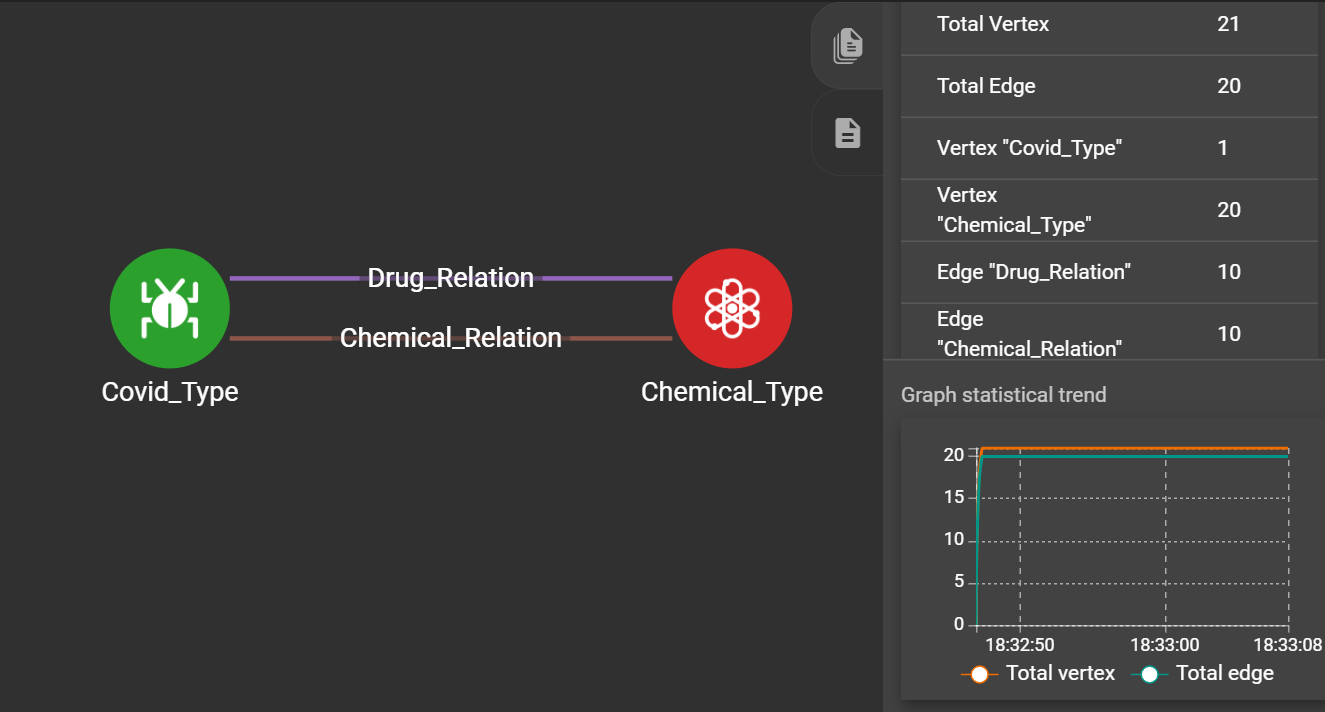

Fig: Graph Schema

In [ ]:
conn.graphname = "Drug"
conn.apiToken = conn.getToken(conn.createSecret())

In [ ]:
conn.upsertVertex('Covid_Type','Covid_19','Covid_19')

In [ ]:
for item in data[:10]:
    conn.upsertVertex('Chemical_Type',item,item)
    conn.upsertEdge('Covid_Type','Covid_19','Drug_Relation','Chemical_Type',item)
for item in data[10:]:
    conn.upsertVertex('Chemical_Type',item,item)
    conn.upsertEdge('Covid_Type','Covid_19','Chemical_Relation','Chemical_Type',item)

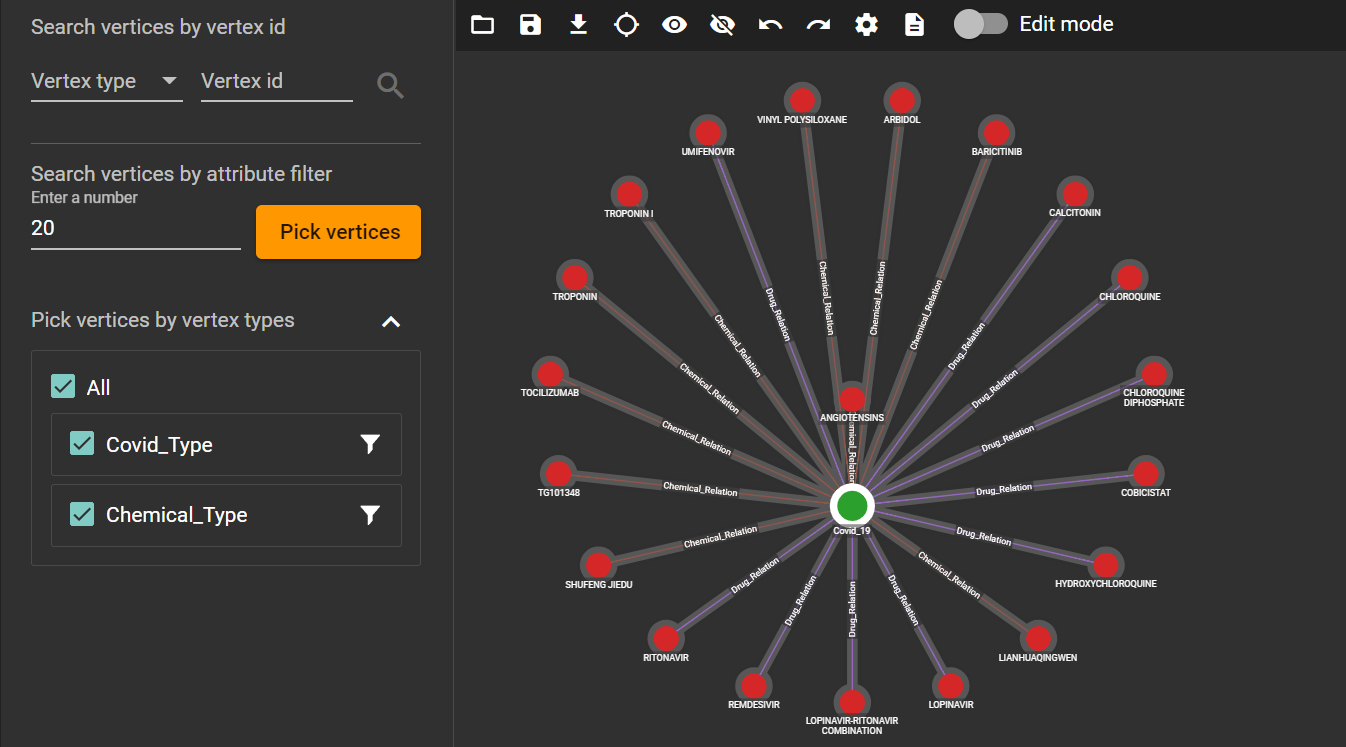